In [1]:
import QuantLib as ql
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math

from scipy import stats
from scipy.stats import norm
from scipy.optimize import least_squares
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(palette = 'viridis')

# All functions

In [2]:
def bs_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    V = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return V

def vega(S0, K, T, r, sigma):
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

def implied_vol(S0, K, T, r, C0):
    sigma_est = 0.2
    it = 100
    for i in range(it):
        sigma_est -= (bs_call(S0, K, T, r, sigma_est) - C0) / vega(S0, K, T, r, sigma_est)
    return sigma_est

In [3]:
def merton_model(S0, K, T, r, sigma, lambd, m, s):
    
    V = 0
    
    for n in range(80):
        lambd_hat = lambd * (1 + m)
        variance_merton = sigma ** 2 + n * (s ** 2) / T
        sigma_merton = np.sqrt(variance_merton)
        gamma = np.log(1 + m)
        r_merton = r - lambd * m + n * gamma / T
        
        numerator = np.exp(-lambd_hat * T) * (lambd_hat * T) ** n
        denumerator = math.factorial(n)
        factor = numerator / denumerator
            
        V_BS = bs_call(S0, K, T, r_merton, sigma_merton)
        V = V + factor * V_BS
    return V

In [4]:
def heston_model(S0, K, start, end, r, v0, kappa, theta, sigma, rho):
    
    S0 = ql.QuoteHandle(ql.SimpleQuote(S0))
    ql.Settings.instance().evaluationDate = start
    
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, r, ql.Actual365NoLeap()))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, 0, ql.Actual365Fixed()))
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, int(K))
    exercise = ql.EuropeanExercise(end)
    option = ql.VanillaOption(payoff, exercise)

    process = ql.HestonProcess(flat_ts, dividend_ts, S0, v0, kappa, theta, sigma, rho)

    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)

    option.setPricingEngine(engine)

    a = option.NPV()
    return a

In [5]:
def bates_model(S0, K, start, end, r, v0, kappa, theta, sigma, rho, lambd, m, s):
    
    S0 = ql.QuoteHandle(ql.SimpleQuote(S0))
    ql.Settings.instance().evaluationDate = start
    
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, r, ql.Actual365NoLeap()))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, 0, ql.Actual365Fixed()))
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, int(K))
    exercise = ql.EuropeanExercise(end)
    option = ql.VanillaOption(payoff, exercise)

    process = ql.BatesProcess(flat_ts, dividend_ts, S0, v0, kappa, theta, sigma, rho, lambd, m, s)

    model = ql.BatesModel(process)
    engine = ql.BatesEngine(model)

    option.setPricingEngine(engine)

    a = option.NPV()
    return a

# Data preprocessing

In [6]:
data = pd.read_excel('data.xlsx', sheet_name = 'All')
data.dropna(inplace = True)
data.set_index('Strike', inplace = True)
data = data.loc[70000:76000]

In [7]:
data.head()

,Price T1,IV T1,Price T2,IV T2,Price T3,IV T3
Strike,,,,,,
70000,4192.0,0.1919,4253.0,0.2085,4487,0.1602
70250,3944.0,0.1881,4014.0,0.2048,4278,0.1602
70500,3698.0,0.1847,3777.0,0.2013,4074,0.1604
70750,3453.0,0.1816,3543.0,0.1979,3875,0.1607
71000,3209.0,0.1788,3312.0,0.1947,3681,0.1611


In [8]:
data.describe()

,Price T1,IV T1,Price T2,IV T2,Price T3,IV T3
count,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,1719.040000,0.177768,1944.12000,0.189488,2534.440000,0.171260
std,1298.215746,0.007781,1203.58528,0.008647,1028.727048,0.009857
min,192.000000,0.169200,468.00000,0.179800,1164.000000,0.160200
25%,557.000000,0.171200,891.00000,0.181900,1658.000000,0.162400
50%,1424.000000,0.176100,1686.00000,0.187200,2364.000000,0.168900
75%,2730.000000,0.183600,2863.00000,0.195000,3313.000000,0.178700
max,4192.000000,0.193500,4253.00000,0.208500,4487.000000,0.190600


In [9]:
S0 = 73718
T_fut = 41 / 365
start = ql.Date(8, 5, 2020)
end = np.array([ql.Date(14, 5, 2020), ql.Date(21, 5, 2020), ql.Date(18, 6, 2020)])
T = (end - start) / 365
r = 0.082

implieds = np.array([data['IV T1'], data['IV T2'], data['IV T3']])
prices = np.array([data['Price T1'], data['Price T2'], data['Price T3']])
strikes = data.index

S0 = S0 * np.exp(-r * T_fut)
print('Future price at t = 0 is {0:.5f}'.format(S0))

Future price at t = 0 is 73042.10413


# Build volatility surface

In [10]:
strikes_plt, T_plt = np.meshgrid(strikes, T)

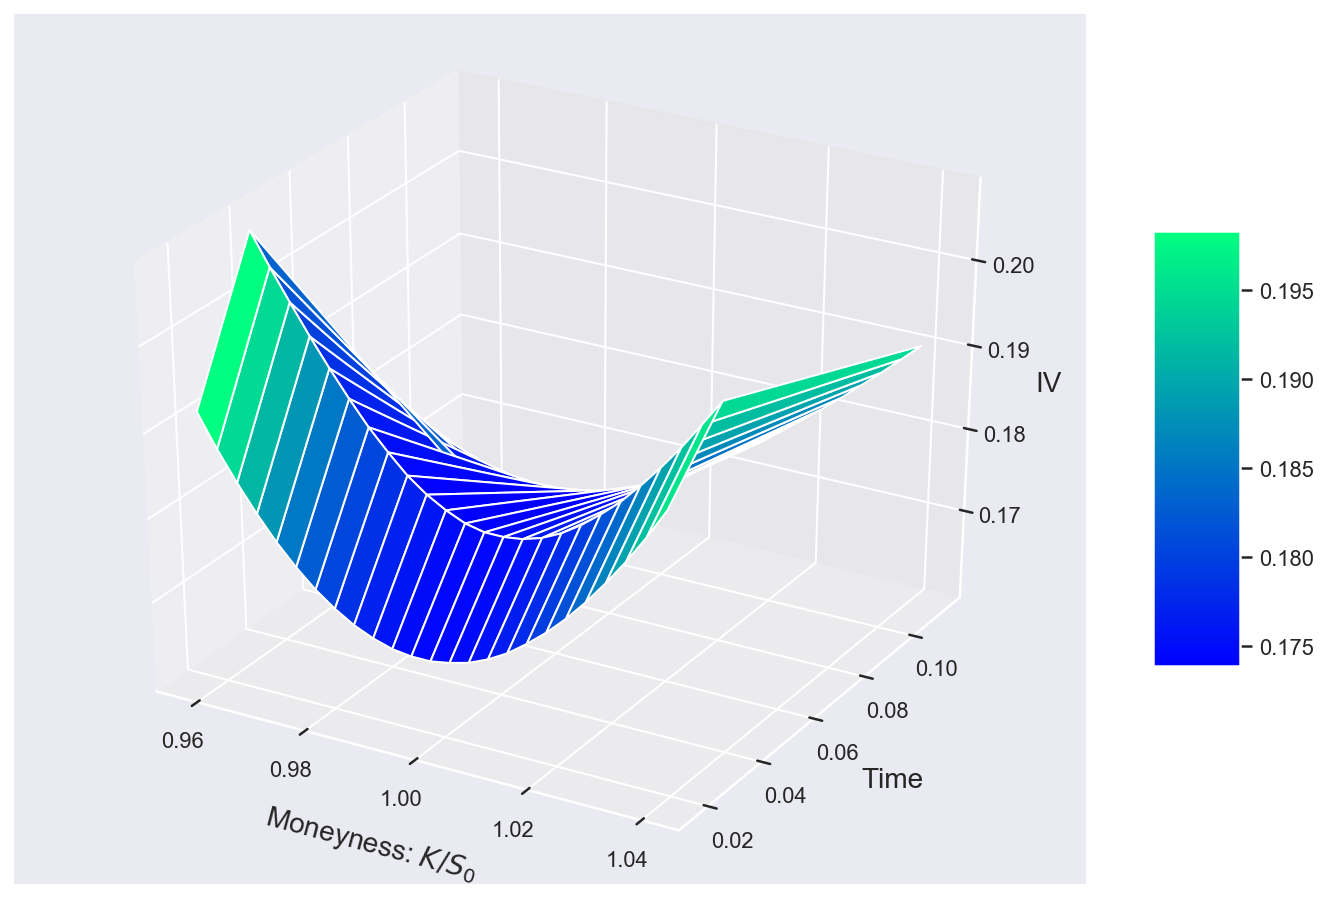

In [11]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = '3d')

surf = ax.plot_surface(strikes_plt / S0, T_plt, implieds, cmap = plt.cm.winter, alpha = 1)

ax.set_xlabel('Moneyness: $K / S_{0}$', labelpad = 12, size = 14)
ax.set_ylabel('Time', labelpad = 12, size = 14)
ax.set_zlabel('IV', size = 14)
fig.colorbar(surf, shrink = 0.5, aspect = 5)

# plt.savefig('Multiple model pictures/Volatility surface.pdf')
plt.show()

# Models calibration

## Calibrate Merton model

In [12]:
def multi_optimizer(parms):
    sigma, lambd, m, s = parms
    
    rows, cols = len(T), len(strikes)
    answer = np.zeros((rows, cols), dtype = np.float64)
    
    for i in range(rows):
        for j in range(cols):
            answer[i][j] = implieds[i][j] - implied_vol(S0, strikes[j], T[i], r, \
                                                     merton_model(S0, strikes[j], T[i], r, \
                                                                  sigma, lambd, m, s))
            
            
    return answer.ravel()

In [13]:
%%time
initial_guess = (0.1, 0.1, 0.1, 0.1)

opt_params = least_squares(multi_optimizer, x0 = initial_guess, \
                           bounds = ((0, 0, 0, 0), (np.infty, np.infty, np.infty, np.infty)), \
                           method = 'trf', verbose = 0)

CPU times: user 15min 45s, sys: 6.71 s, total: 15min 52s
Wall time: 16min 21s


In [14]:
print('sigma = %f, lambd = %f, m = %f, s = %f' % (opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3]))

sigma = 0.137733, lambd = 20.684005, m = 0.002042, s = 0.025677


### Use calibrated parameters to calculate Merton's call price

In [15]:
rows, cols = len(T), len(strikes)

mertons_multi = np.zeros((rows, cols), dtype = float)

In [16]:
for i in range(rows):
    for j in range(cols):
        mertons_multi[i][j] = merton_model(S0, strikes[j], T[i], r, \
                                           opt_params.x[0], opt_params.x[1], \
                                           opt_params.x[2], opt_params.x[3])

### From calibrated Merton's call price extract implied volatility

In [17]:
rows, cols = len(T), len(strikes)
mertons_multi_iv = np.zeros((rows, cols), dtype = np.float64)

In [18]:
for i in range(rows):
    for j in range(cols):
        mertons_multi_iv[i][j] = implied_vol(S0, strikes[j], T[i], r, mertons_multi[i][j])

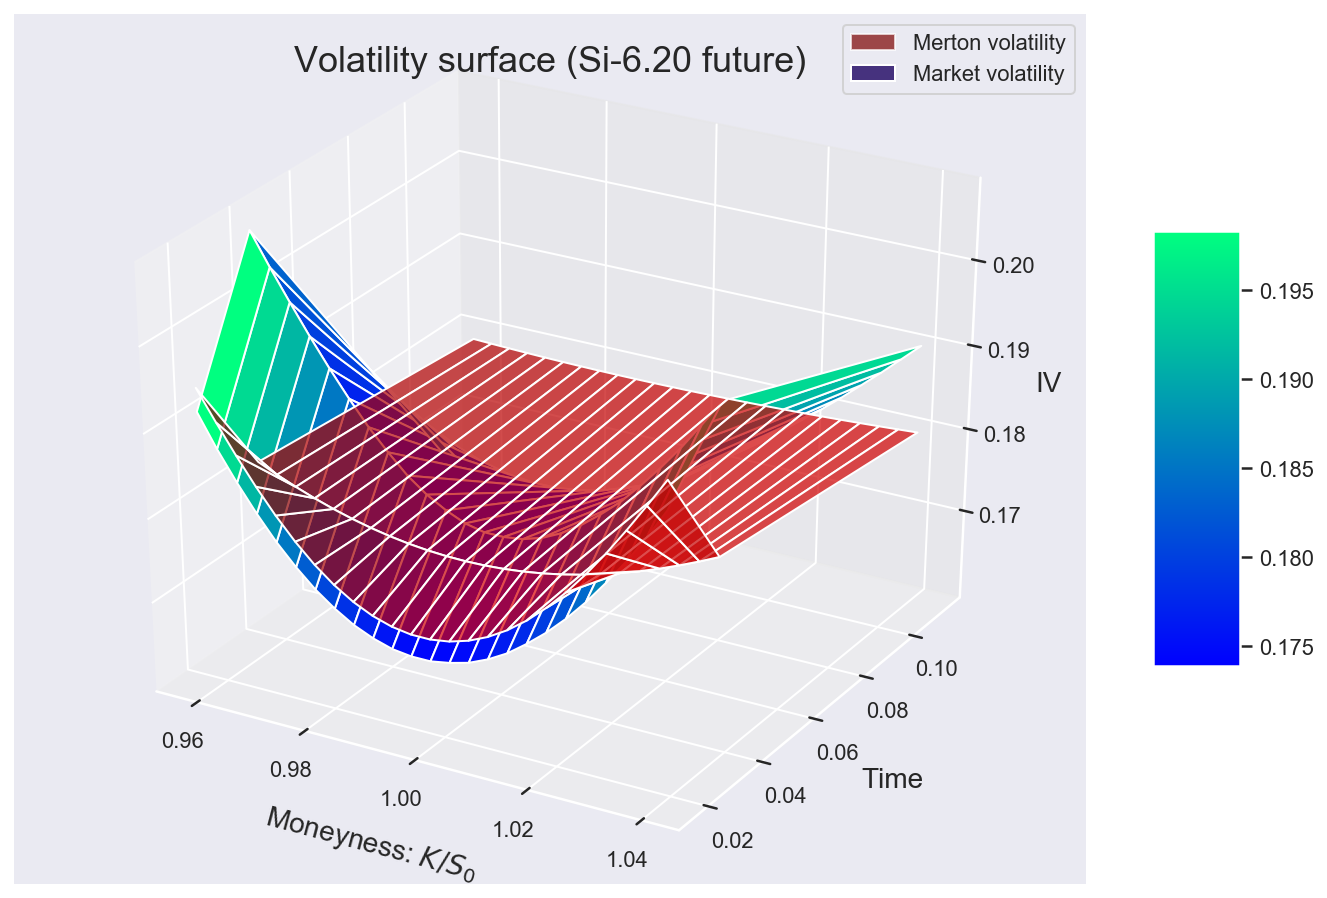

In [19]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection = '3d')

surf = ax.plot_surface(strikes_plt / S0, T_plt, mertons_multi_iv, color = 'red', alpha = 0.7, label = 'Merton volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d

surf = ax.plot_surface(strikes_plt / S0, T_plt, implieds, cmap = plt.cm.winter, label = 'Market volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d


ax.set_title('Volatility surface (Si-6.20 future)', size = 18)
ax.set_xlabel('Moneyness: $K / S_{0}$', labelpad = 12, size = 14)
ax.set_ylabel('Time', labelpad = 12, size = 14)
ax.set_zlabel('IV', size = 14)
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.legend()

# plt.savefig('Multiple model pictures/Merton multiple iv.pdf')
plt.show()

In [20]:
mse = mean_squared_error(mertons_multi_iv, implieds)
mae = mean_absolute_error(mertons_multi_iv, implieds)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 0.00011
MAE: 0.00828


### Monte Carlo with best parameters

In [21]:
sigma = opt_params.x[0]
lambd = opt_params.x[1]
m = opt_params.x[2]
s = opt_params.x[3]

In [22]:
np.random.seed(22)

M = 252
I = 10000
dt = T_fut / M
rj = lambd * (np.exp(m + 0.5 * s ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = np.random.standard_normal((M + 1, I))
sn2 = np.random.standard_normal((M + 1, I))
poi = np.random.poisson(lambd * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sn1[t]) \
                       + (np.exp(m + s * sn2[t]) - 1) * poi[t])
    S[t] = np.maximum(S[t], 0)

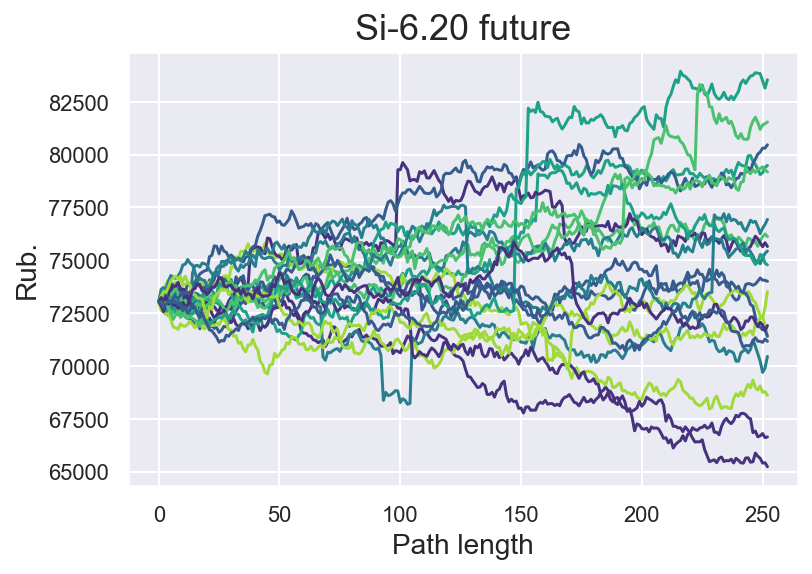

In [23]:
plt.plot(S[:, :20])

plt.title('Si-6.20 future', size = 18)
plt.xlabel('Path length', size = 14)
plt.ylabel('Rub.', size = 14)

# plt.savefig('Multiple model pictures/Merton multiple MC.pdf')
plt.show()

In [24]:
error = np.std(S) / np.sqrt(np.mean(S) * I)
print('Error of MC estimator = {0:.5%}'.format(error))

Error of MC estimator = 11.66975%


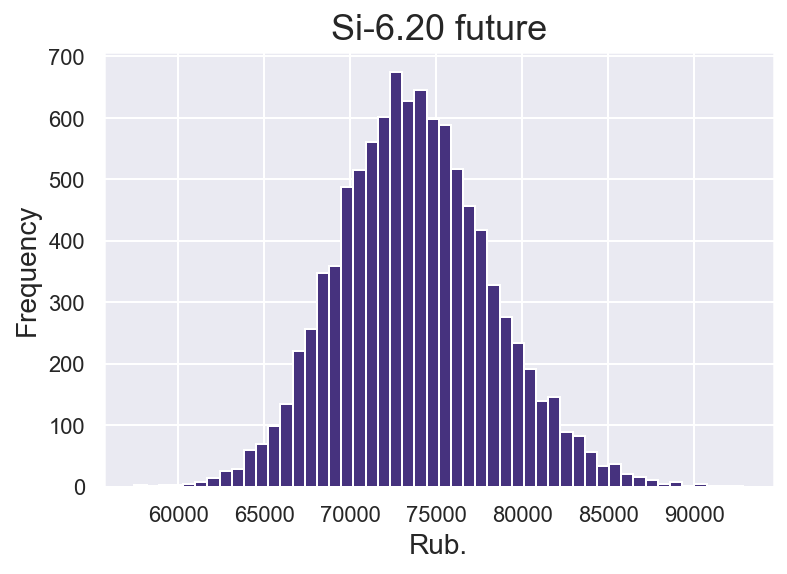

In [25]:
plt.hist(S[-1], bins = 50)

plt.title('Si-6.20 future', size = 18)

plt.xlabel('Rub.', size = 14)
plt.ylabel('Frequency', size = 14)

# plt.savefig('Multiple model pictures/Merton multiple price distribution.pdf')
plt.show()

In [26]:
def print_statistics(array):
    sta = sp.stats.describe(array)
    print("%14s %15s" % ('statistic', 'Price'))
    print(30 * "-")
    print("%14s %15.5f" % ('size', sta[0]))
    print("%14s %15.5f" % ('min', sta[1][0]))
    print("%14s %15.5f" % ('max', sta[1][1]))
    print("%14s %15.5f" % ('mean', sta[2]))
    print("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print("%14s %15.5f" % ('skew', sta[4]))
    print("%14s %15.5f" % ('kurtosis', sta[5]))

In [27]:
print_statistics(S[-1])

     statistic           Price
------------------------------
          size     10000.00000
           min     57460.93864
           max     92828.20011
          mean     73792.30144
           std      4470.02282
          skew         0.22916
      kurtosis         0.19186


## Calibrate Heston model

In [28]:
def multi_optimizer(parms):
    v0, kappa, theta, sigma, rho = parms
    
    rows, cols = len(T), len(strikes)
    answer = np.zeros((rows, cols), dtype = np.float64)
    
    for i in range(rows):
        for j in range(cols):
            answer[i][j] = implieds[i][j] - implied_vol(S0, strikes[j], T[i], r, \
                                                     heston_model(S0, strikes[j], start, end[i], r, \
                                                                  v0, kappa, theta, sigma, rho))
            
            
    return answer.ravel()

In [29]:
%%time
initial_guess = (0.1, 0.1, 0.1, 0.1, 0.1)

opt_params = least_squares(multi_optimizer, x0 = initial_guess, \
                           bounds = ((0, 0, 0, 0, -1), (np.infty, np.infty, np.infty, np.infty, 1)), \
                           method = 'trf', verbose = 0)

CPU times: user 10min 16s, sys: 4.48 s, total: 10min 21s
Wall time: 11min 19s


In [30]:
print('v0 = %f, Kappa = %f, Theta = %f, Sigma = %f, Rho = %f' % \
      (opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3], opt_params.x[4]))

v0 = 0.033585, Kappa = 5.147745, Theta = 0.043074, Sigma = 1.208913, Rho = 0.122086


### Use calibrated parameters to calculate Heston's call price

In [31]:
rows, cols = len(T), len(strikes)

hestons_multi = np.zeros((rows, cols), dtype = float)  #create array for call options

In [32]:
for i in range(rows):
    for j in range(cols):
        hestons_multi[i][j] = heston_model(S0, strikes[j], \
                                           start, end[i], r, \
                                           opt_params.x[0], opt_params.x[1], \
                                           opt_params.x[2], opt_params.x[3], opt_params.x[4])

### From calibrated Heston's call price extract implied volatility

In [33]:
rows, cols = len(T), len(strikes)
hestons_multi_iv = np.zeros((rows, cols), dtype = np.float64)

In [34]:
for i in range(rows):
    for j in range(cols):
        hestons_multi_iv[i][j] = implied_vol(S0, strikes[j], T[i], r, hestons_multi[i][j])

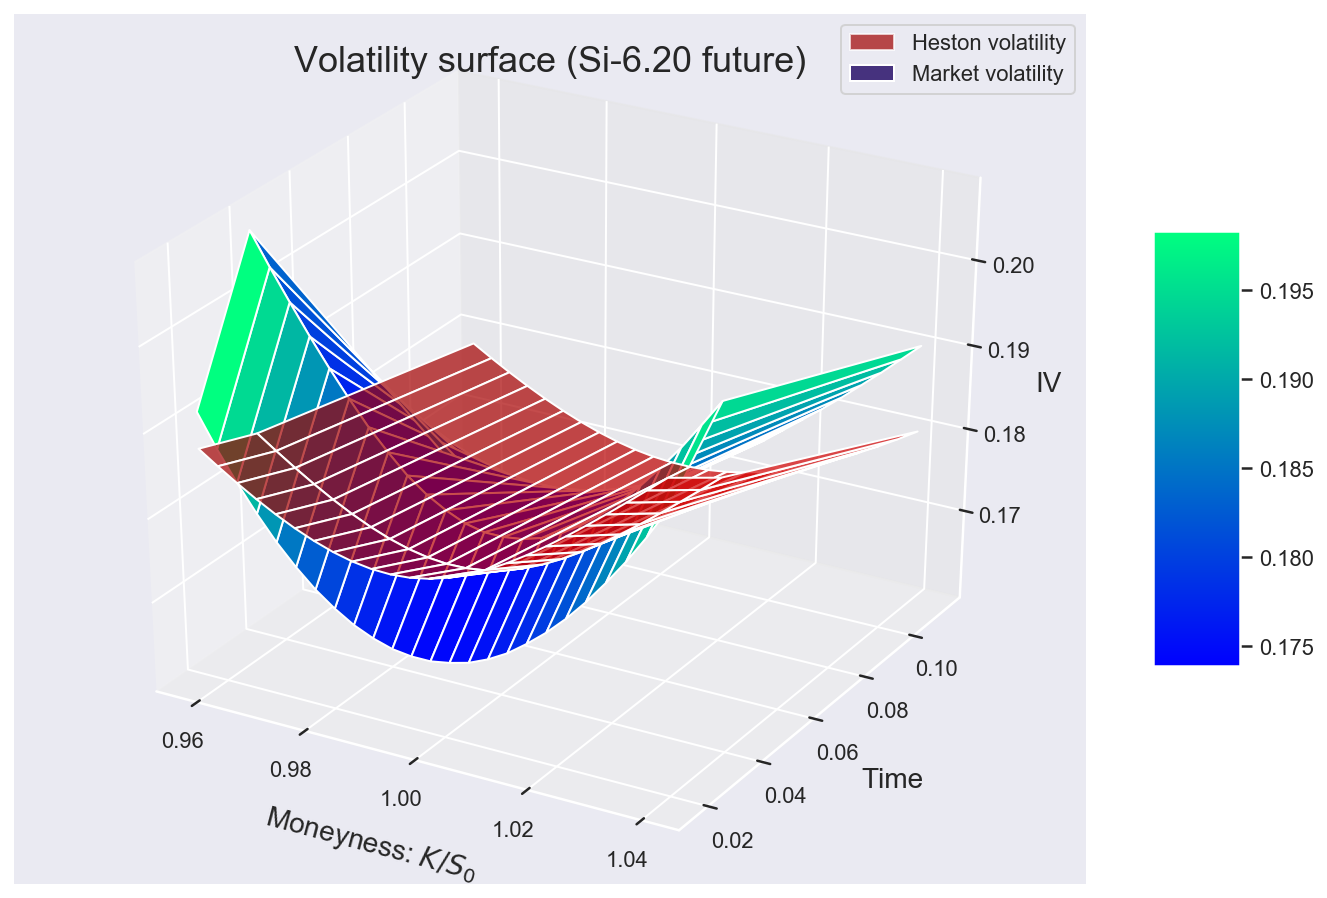

In [35]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection = '3d')

surf = ax.plot_surface(strikes_plt / S0, T_plt, hestons_multi_iv, color = 'red', alpha = 0.7, label = 'Heston volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d

surf = ax.plot_surface(strikes_plt / S0, T_plt, implieds, cmap = plt.cm.winter, label = 'Market volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d


ax.set_title('Volatility surface (Si-6.20 future)', size = 18)
ax.set_xlabel('Moneyness: $K / S_{0}$', labelpad = 12, size = 14)
ax.set_ylabel('Time', labelpad = 12, size = 14)
ax.set_zlabel('IV', size = 14)
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.legend()

# plt.savefig('Multiple model pictures/Heston multiple iv.pdf')
plt.show()

In [36]:
mse = mean_squared_error(hestons_multi_iv, implieds)
mae = mean_absolute_error(hestons_multi_iv, implieds)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 0.00009
MAE: 0.00791


### Monte Carlo with best parameters

In [37]:
v0 = opt_params.x[0]
kappa = opt_params.x[1]
theta = opt_params.x[2]
sigma = opt_params.x[3]
rho = opt_params.x[4]

In [38]:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

In [39]:
np.random.seed(22)

M = 252
I = 10000
ran_num = np.random.standard_normal((2, M + 1, I))
dt = T_fut / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt \
             + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt) * ran[1])
    v = np.maximum(vh, 0)

In [40]:
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

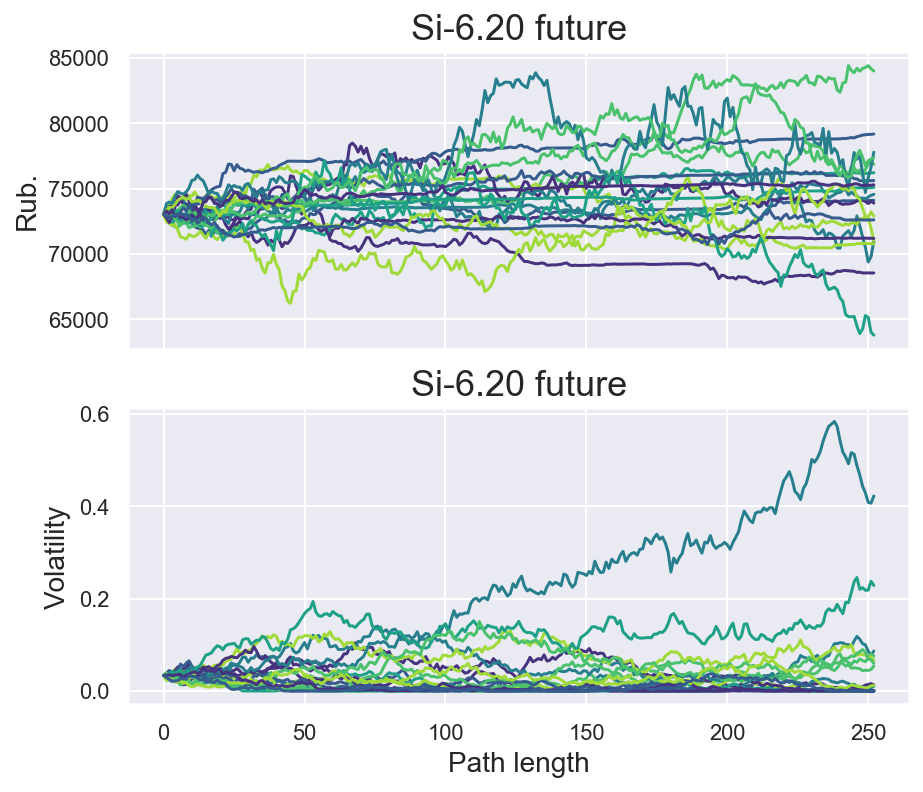

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (7, 6))

ax1.set_title('Si-6.20 future', size = 18)
ax1.plot(S[:, :20])
ax1.set_ylabel('Rub.', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.plot(v[:, :20])
ax2.set_xlabel('Path length', size = 14)
ax2.set_ylabel('Volatility', size = 14)

# plt.savefig('Multiple model pictures/Heston multiple MC.pdf')
plt.show()

In [42]:
error = np.std(S) / np.sqrt(np.mean(S) * I)
print('Error of MC estimator = {0:.5%}'.format(error))

Error of MC estimator = 12.50019%


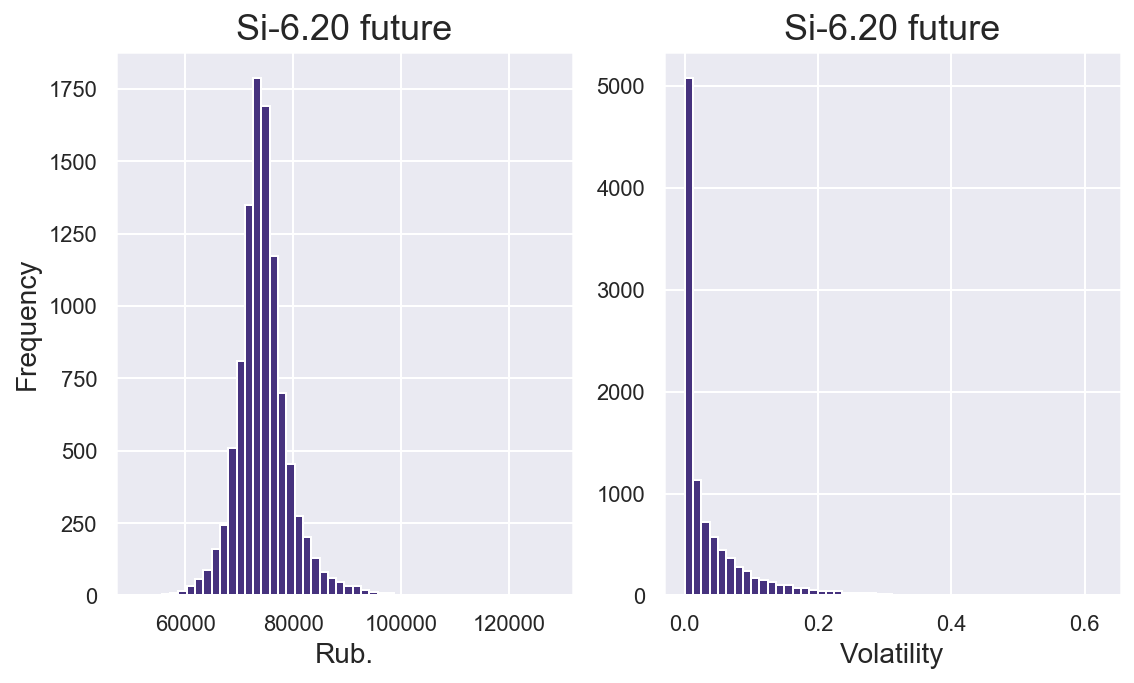

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))

ax1.set_title('Si-6.20 future', size = 18)
ax1.hist(S[-1], bins = 50)
ax1.set_xlabel('Rub.', size = 14)
ax1.set_ylabel('Frequency', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.hist(v[-1], bins = 50)
ax2.set_xlabel('Volatility', size = 14)

# plt.savefig('Multiple model pictures/Heston multiple price distribution.pdf')
plt.show()

In [44]:
def print_statistics(a1, a2):

    sta1 = sp.stats.describe(a1)
    sta2 = sp.stats.describe(a2)
    print("%14s %14s %14s" % ('statistic', 'Price', 'Volatility'))
    print(45 * "-")
    print("%14s %14.3f %14.3f" % ('size', sta1[0], sta2[0]))
    print("%14s %14.3f %14.3f" % ('min', sta1[1][0], sta2[1][0]))
    print("%14s %14.3f %14.3f" % ('max', sta1[1][1], sta2[1][1]))
    print("%14s %14.3f %14.3f" % ('mean', sta1[2], sta2[2]))
    print("%14s %14.3f %14.3f" % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print("%14s %14.3f %14.3f" % ('skew', sta1[4], sta2[4]))
    print("%14s %14.3f %14.3f" % ('kurtosis', sta1[5], sta2[5]))

In [45]:
print_statistics(S[-1], v[-1])

     statistic          Price     Volatility
---------------------------------------------
          size      10000.000      10000.000
           min      50995.235          0.000
           max     127952.775          0.623
          mean      74384.762          0.038
           std       4915.748          0.061
          skew          0.999          2.878
      kurtosis          5.371         11.444


## Calibrate Bates model

In [46]:
def multi_optimizer(parms):
    v0, kappa, theta, sigma, rho, lambd, m, s = parms
    
    rows, cols = len(T), len(strikes)
    answer = np.zeros((rows, cols), dtype = np.float64)
    
    for i in range(rows):
        for j in range(cols):
            answer[i][j] = implieds[i][j] - implied_vol(S0, strikes[j], T[i], r, \
                                                     bates_model(S0, strikes[j], start, end[i], r, \
                                                                  v0, kappa, theta, sigma, rho, \
                                                                 lambd, m, s))
            
            
    return answer.ravel()

In [47]:
%%time
initial_guess = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

opt_params = least_squares(multi_optimizer, x0 = initial_guess, \
                           bounds = ((0, 0, 0, 0, -1, 0, 0, 0), (np.infty, np.infty, np.infty, \
                                                                 np.infty, 1, np.infty, np.infty, np.infty)), \
                           method = 'trf', verbose = 0)

CPU times: user 14min 12s, sys: 5.58 s, total: 14min 17s
Wall time: 15min 27s


In [48]:
print('v0 = %f, Kappa = %f, Theta = %f, Sigma = %f, Rho = %f, lambd = %f, m = %f, s = %f' % \
      (opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3], opt_params.x[4], \
       opt_params.x[5], opt_params.x[6], opt_params.x[7]))

v0 = 0.028998, Kappa = 3.021442, Theta = 0.000000, Sigma = 0.402574, Rho = 0.301535, lambd = 0.644257, m = 0.000000, s = 0.132920


### Use calibrated parameters to calculate Bates's call price

In [49]:
rows, cols = len(T), len(strikes)

bates_multi = np.zeros((rows, cols), dtype = float)  #create array for call options

In [50]:
for i in range(rows):
    for j in range(cols):
        bates_multi[i][j] = bates_model(S0, strikes[j], \
                                           start, end[i], r, \
                                           opt_params.x[0], opt_params.x[1], \
                                           opt_params.x[2], opt_params.x[3], opt_params.x[4], \
                                        opt_params.x[5], opt_params.x[6], opt_params.x[7])

### From calibrated Bates's call price extract implied volatility

In [51]:
rows, cols = len(T), len(strikes)
bates_multi_iv = np.zeros((rows, cols), dtype = np.float64)

In [52]:
for i in range(rows):
    for j in range(cols):
        bates_multi_iv[i][j] = implied_vol(S0, strikes[j], T[i], r, bates_multi[i][j])

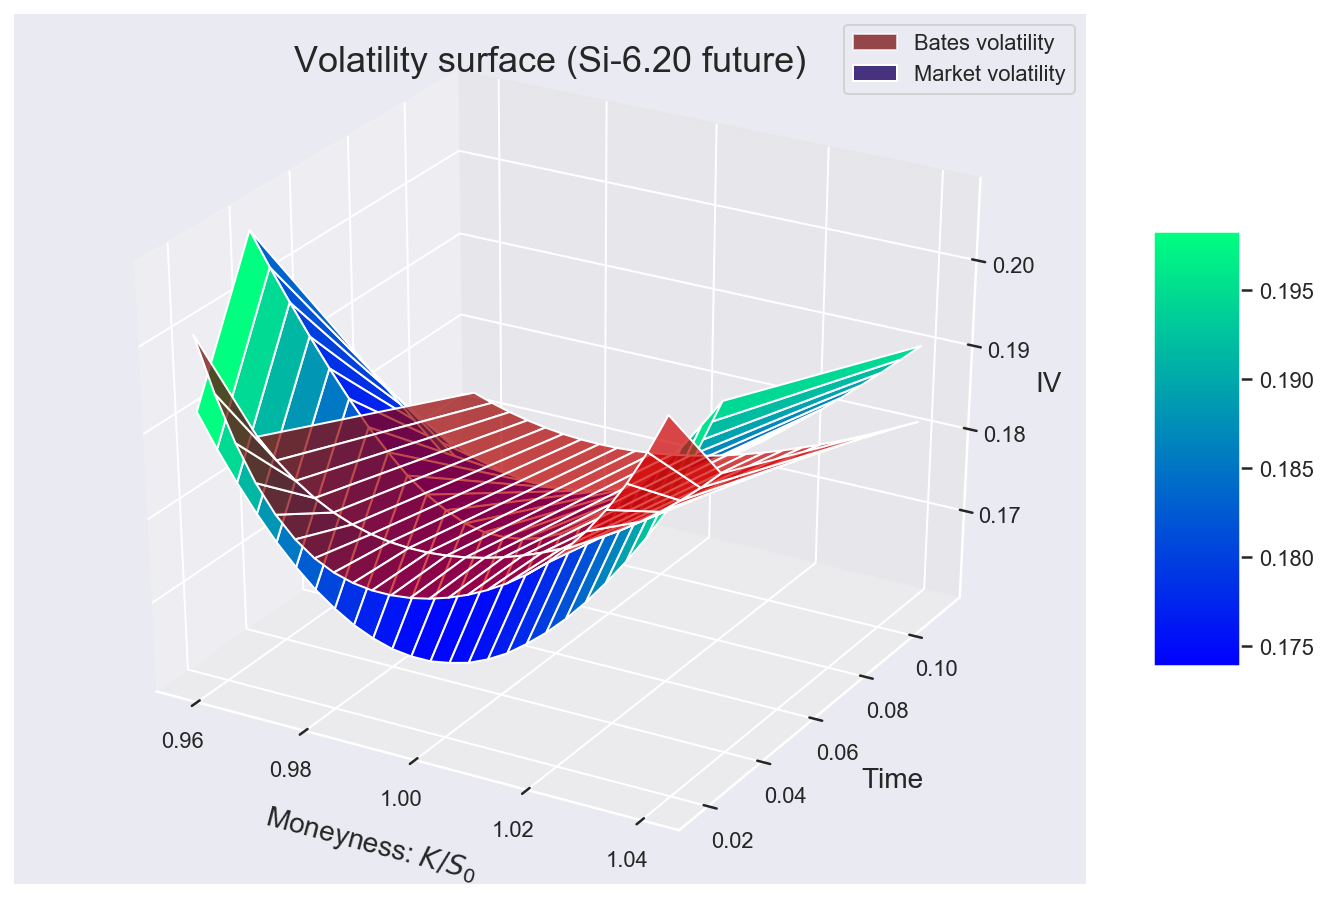

In [53]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection = '3d')

surf = ax.plot_surface(strikes_plt / S0, T_plt, bates_multi_iv, color = 'red', alpha = 0.7, label = 'Bates volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d

surf = ax.plot_surface(strikes_plt / S0, T_plt, implieds, cmap = plt.cm.winter, label = 'Market volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d


ax.set_title('Volatility surface (Si-6.20 future)', size = 18)
ax.set_xlabel('Moneyness: $K / S_{0}$', labelpad = 12, size = 14)
ax.set_ylabel('Time', labelpad = 12, size = 14)
ax.set_zlabel('IV', size = 14)
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.legend()

# plt.savefig('Multiple model pictures/Bates multiple iv.pdf')
plt.show()

In [54]:
mse = mean_squared_error(bates_multi_iv, implieds)
mae = mean_absolute_error(bates_multi_iv, implieds)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 0.00007
MAE: 0.00711


### Monte Carlo with best parameters

In [55]:
v0 = opt_params.x[0]
kappa = opt_params.x[1]
theta = opt_params.x[2]
sigma = opt_params.x[3]
rho = opt_params.x[4]

lambd = opt_params.x[5]
m = opt_params.x[6]
s = opt_params.x[7]

In [56]:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

In [57]:
np.random.seed(22)

M = 252
I = 10000
ran_num = np.random.standard_normal((2, M + 1, I))
dt = T_fut / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt \
             + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt) * ran[1])
    v = np.maximum(vh, 0)

In [58]:
sn2 = np.random.standard_normal((M + 1, I))
poi = np.random.poisson(lambd * dt, (M + 1, I))

rj = lambd * (np.exp(m + 0.5 * s ** 2) - 1)
S = np.zeros_like(ran_num[0])
S[0] = S0

for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * v[t]) * dt + np.sqrt(v[t]) * np.sqrt(dt) * ran[0]) \
                       + (np.exp(m + s * sn2[t]) - 1) * poi[t])
    S[t] = np.maximum(S[t], 0)

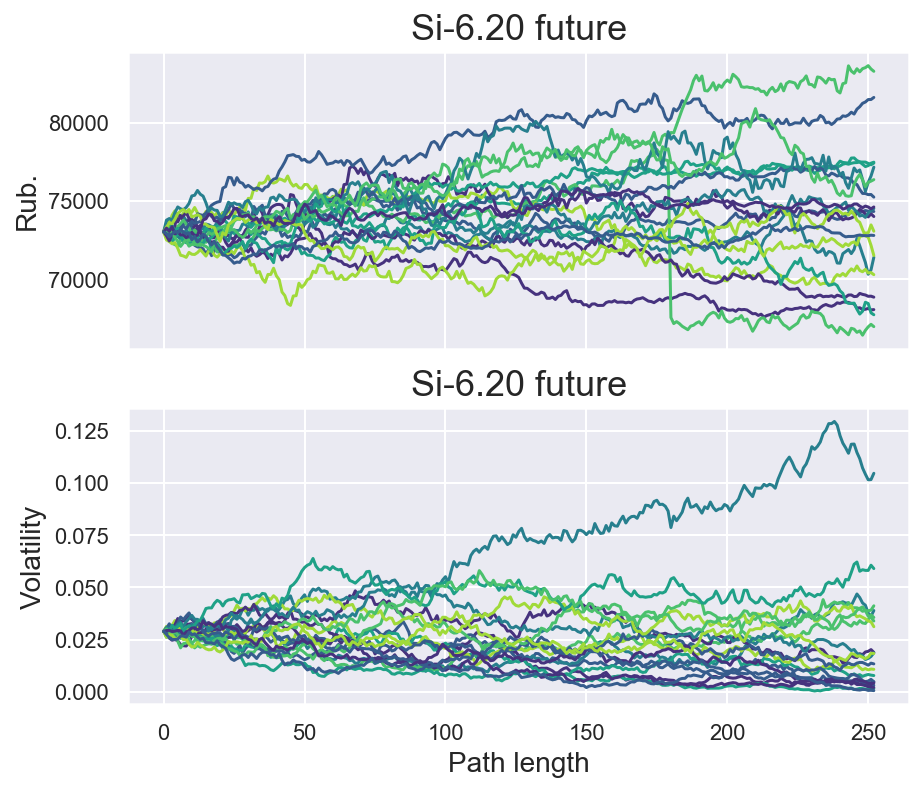

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (7, 6))

ax1.set_title('Si-6.20 future', size = 18)
ax1.plot(S[:, :20])
ax1.set_ylabel('Rub.', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.plot(v[:, :20])
ax2.set_xlabel('Path length', size = 14)
ax2.set_ylabel('Volatility', size = 14)

# plt.savefig('Multiple model pictures/Bates multiple MC.pdf')
plt.show()

In [60]:
error = np.std(S) / np.sqrt(np.mean(S) * I)
print('Error of MC estimator = {0:.5%}'.format(error))

Error of MC estimator = 12.92505%


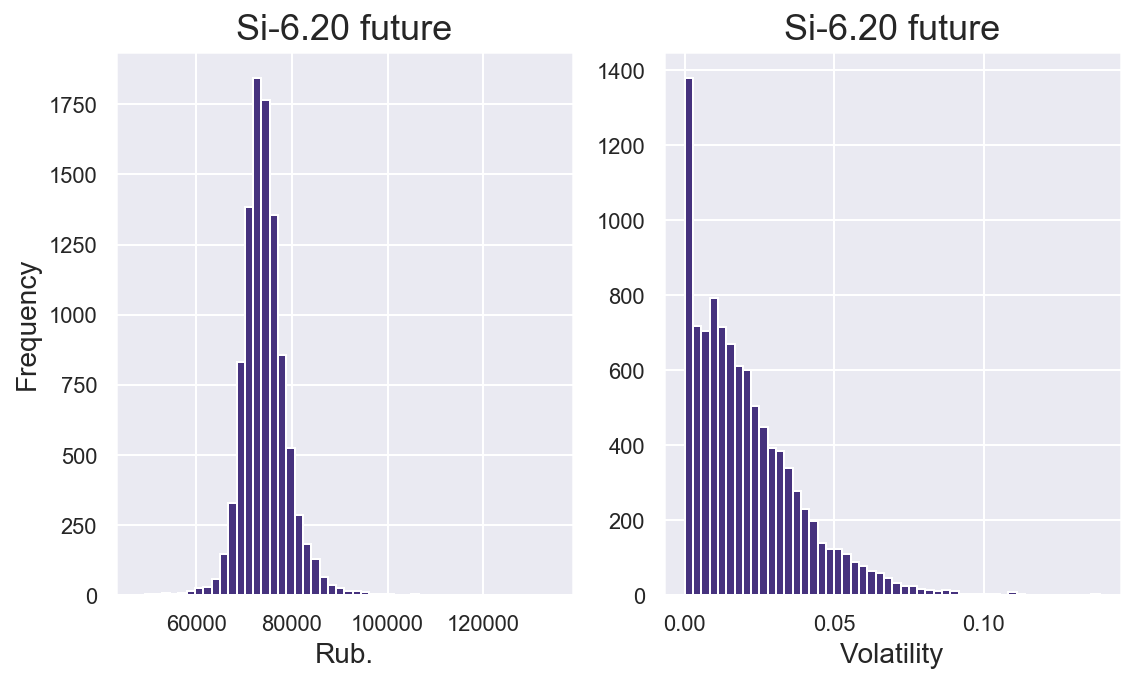

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))

ax1.set_title('Si-6.20 future', size = 18)
ax1.hist(S[-1], bins = 50)
ax1.set_xlabel('Rub.', size = 14)
ax1.set_ylabel('Frequency', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.hist(v[-1], bins = 50)
ax2.set_xlabel('Volatility', size = 14)

# plt.savefig('Multiple model pictures/Bates multiple price distribution.pdf')
plt.show()

In [62]:
def print_statistics(a1, a2):

    sta1 = sp.stats.describe(a1)
    sta2 = sp.stats.describe(a2)
    print("%14s %14s %14s" % ('statistic', 'Price', 'Volatility'))
    print(45 * "-")
    print("%14s %14.3f %14.3f" % ('size', sta1[0], sta2[0]))
    print("%14s %14.3f %14.3f" % ('min', sta1[1][0], sta2[1][0]))
    print("%14s %14.3f %14.3f" % ('max', sta1[1][1], sta2[1][1]))
    print("%14s %14.3f %14.3f" % ('mean', sta1[2], sta2[2]))
    print("%14s %14.3f %14.3f" % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print("%14s %14.3f %14.3f" % ('skew', sta1[4], sta2[4]))
    print("%14s %14.3f %14.3f" % ('kurtosis', sta1[5], sta2[5]))

In [63]:
print_statistics(S[-1], v[-1])

     statistic          Price     Volatility
---------------------------------------------
          size      10000.000      10000.000
           min      47536.210          0.000
           max     134421.504          0.139
          mean      74296.347          0.021
           std       4887.233          0.018
          skew          1.078          1.374
      kurtosis          8.192          2.695


# All graphs in one

## Volatility surface

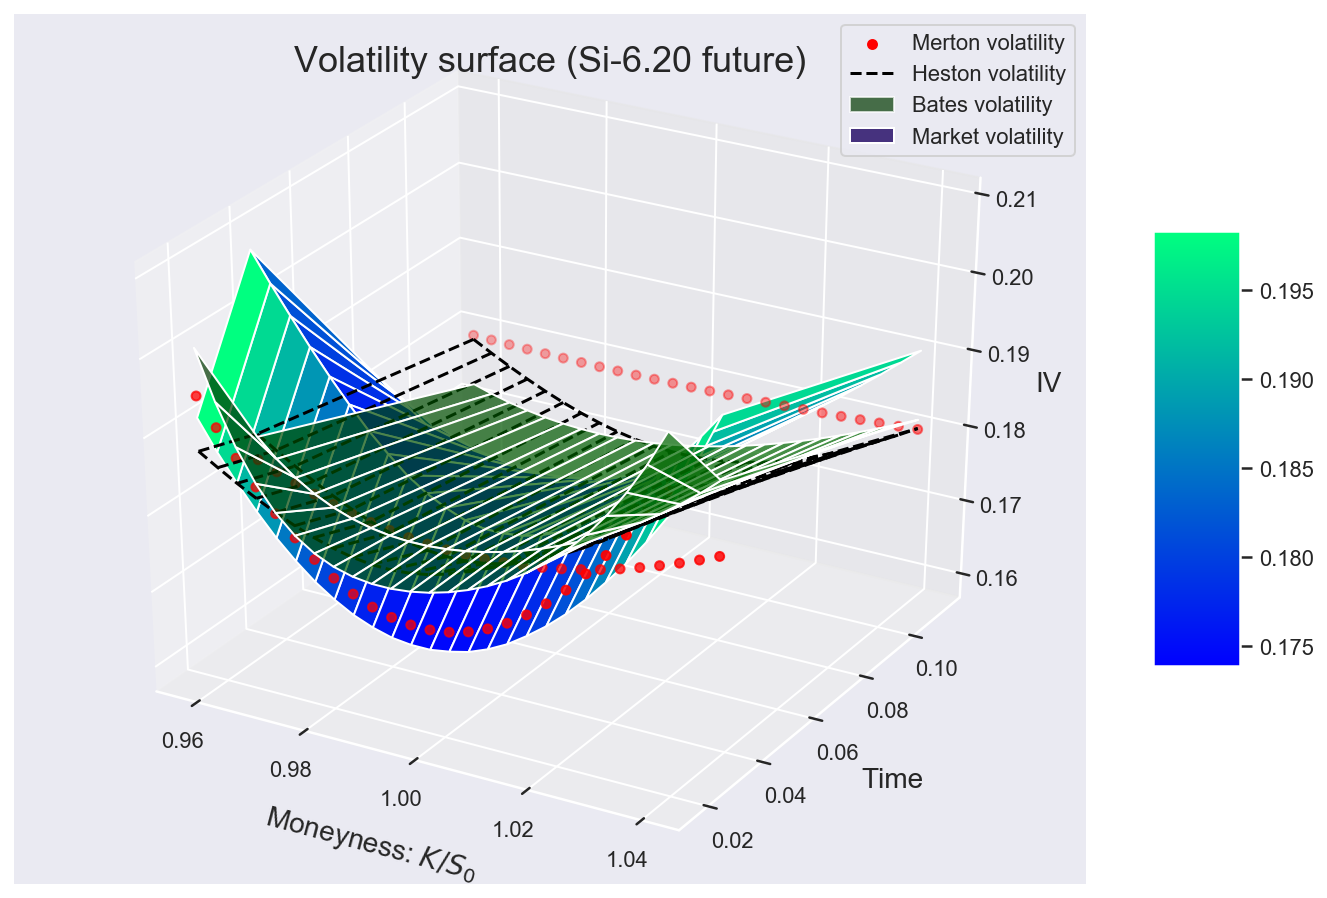

In [64]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection = '3d')

surf = ax.scatter(strikes_plt / S0, T_plt, mertons_multi_iv, color = 'red', linestyle = '-', \
                  marker = 'o', label = 'Merton volatility')

surf = ax.plot_wireframe(strikes_plt / S0, T_plt, hestons_multi_iv, color = 'black', linestyle = '--', \
                         label = 'Heston volatility')

surf = ax.plot_surface(strikes_plt / S0, T_plt, bates_multi_iv, color = 'green', alpha = 0.7, \
                         label = 'Bates volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d

surf = ax.plot_surface(strikes_plt / S0, T_plt, implieds, cmap = plt.cm.winter, label = 'Market volatility')
surf._facecolors2d = surf._facecolors3d
surf._edgecolors2d = surf._edgecolors3d


ax.set_title('Volatility surface (Si-6.20 future)', size = 18)
ax.set_xlabel('Moneyness: $K / S_{0}$', labelpad = 12, size = 14)
ax.set_ylabel('Time', labelpad = 12, size = 14)
ax.set_zlabel('IV', size = 14)
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.legend()

# plt.savefig('Multiple model pictures/All multiple iv.pdf')
plt.show()